# Download Open Images Dataset

In [1]:
import pandas as pd
import sys
import os
import cv2
input_txt = 'data_download.txt'

# set limit for train, test and validation set for images to be downloaded
train_limit = 200000
test_limit = 50000
val_limit = 50000

In [2]:
train_df = pd.read_csv('open_images_v4/train-annotations-bbox.csv')
train_df_filtered = train_df.drop_duplicates('ImageID').reset_index(drop=True)
val_df = pd.read_csv('open_images_v4/validation-annotations-bbox.csv')
val_df_filtered = val_df.drop_duplicates('ImageID').reset_index(drop=True)
test_df = pd.read_csv('open_images_v4/test-annotations-bbox.csv')
test_df_filtered = test_df.drop_duplicates('ImageID').reset_index(drop=True)

# get class mapping 
class_df = pd.read_csv('open_images_v4/class-descriptions-boxable.csv', header=None)
class_df.index = class_df[0]
class_df = class_df.drop(columns=[0])
class_map = class_df.to_dict()[1]

# update LabelName with class
test_df['LabelName'] = test_df['LabelName'].map(class_map)
val_df['LabelName'] = val_df['LabelName'].map(class_map)
train_df['LabelName'] = train_df['LabelName'].map(class_map)

In [6]:
# create list of images to be downloaded
with open(f"open_images_v4/{input_txt}", "w+") as f:
  for idx, row in train_df_filtered.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      f.write("train/"+row['ImageID']+"\r")
      if idx>train_limit:
        break
  for idx, row in val_df_filtered.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      f.write("validation/"+row['ImageID']+"\r")
      if idx>val_limit:
        break
  for idx, row in test_df_filtered.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      f.write("test/"+row['ImageID']+"\r")
      if idx>test_limit:
        break

In [10]:
# download images
!python open_images_v4/downloader.py $"open_images_v4/data_download.txt" --download_folder=$"open_images_v4/images" --num_processes=5

# Update Open Images Dataset to Yolo Format

Final dataset folder looks like below before get into YOLOv7 training,
```
├── yolov7
## └── train
####└── images (folder including all training images)
####└── labels (folder including all training labels)
## └── test
####└── images (folder including all testing images)
####└── labels (folder including all testing labels)
## └── valid
####└── images (folder including all valid images)
####└── labels (folder including all valid labels)
```

Create Custom Config File for Training
We must now develop a customized configuration file. (Be sure to specify the proper directory), as the training process will be entirely dependent on that file.
Create a file with the name “custom.yaml” in the (yolov7/data) folder. In that file, paste the code below. Set the correct path to the dataset folder, alter the number of classes and their names, and then save it.

Make a file that specifies the training configuration. In custom.yaml file, write the following:

```
# path for images
train: /object-detection-classification/yolo/open_images_v4/train/images
val: /object-detection-classification/yolo/open_images_v4/valid/images
test: /object-detection-classification/yolo/open_images_v4/test/images

# number of classes
nc: 5
# list of all classes in sorted order
names: ['Tortoise', 'Container', 'Magpie', 'Sea turtle', 'Football']
```

In [3]:
# get train, test, val subset ImageIDs for which images are downloaded
train_images = []
test_images = []
val_images = []
with open(f'open_images_v4/{input_txt}','r') as f1:
    for line in f1:
        line_split = line.strip().split('/')
        (dataset, ImageID) = line_split
        if dataset=='train':
            train_images.append(ImageID)
        elif dataset=='test':
            test_images.append(ImageID)
        else:
            val_images.append(ImageID)

## Training Images

In [67]:
# for training generate annotation file and image and label folders
import os
import shutil
from tqdm import tqdm

# preparing train data
if not os.path.isdir('open_images_v4/train'):
    os.mkdir('open_images_v4/train')
    os.mkdir('open_images_v4/train/images')
    os.mkdir('open_images_v4/train/labels')

# filter train_df for the images downloaded
train_df = train_df[train_df.ImageID.isin(train_images)]
train_df = train_df.drop_duplicates()
print(train_df.shape)

# for class label index
df = pd.read_csv('open_images_v4/class-descriptions-boxable.csv', header=None)

for idx, row in tqdm(train_df.iterrows()):
      #sys.stdout.write(str(idx) + '\r')
      #sys.stdout.flush()
      if row['ImageID'] in train_images:
        # get image name
        image_name = row['ImageID']

        # get class value
        class_name = row['LabelName']
        class_val = df[df[1]==class_name].index[0]

        # get x_center, y_center, width, height
        x1 = row['XMin']
        x2 = row['XMax']
        y1 = row['YMin']
        y2 = row['YMax']
        width = x2-x1
        height = y2-y1
        x_cent = x1+width/2
        y_cent = y1+height/2

        # check if text file exist
        if os.path.exists(f"open_images_v4/train/labels/{image_name}.txt"):
            # open text file and append
            file1 = open(f"open_images_v4/train/labels/{image_name}.txt", "a")
            L = "\n"+str(class_val)+" "+str(x_cent)+" "+str(y_cent)+" "+str(width)+" "+str(height)
            file1.write(L)
            file1.close()

        else:
            # create text file
            file1 = open(f"open_images_v4/train/labels/{image_name}.txt", "w")  # write mode
            L = str(class_val)+" "+str(x_cent)+" "+str(y_cent)+" "+str(width)+" "+str(height)
            file1.write(L)
            file1.close()

            # copy image file
            shutil.copyfile(f'open_images_v4/images/{image_name}.jpg', f'open_images_v4/train/images/{image_name}.jpg')

(1433339, 13)


1433339it [53:54, 443.08it/s]


## Test Images

In [45]:
# for training generate annotation file and image and label folders
import os
import shutil
from tqdm import tqdm

# preparing train data
if not os.path.isdir('open_images_v4/test'):
    os.mkdir('open_images_v4/test')
    os.mkdir('open_images_v4/test/images')
    os.mkdir('open_images_v4/test/labels')

# filter test_df for the images downloaded
test_df = test_df[test_df.ImageID.isin(test_images)]
print(test_df.shape)

# for class label index
df = pd.read_csv('open_images_v4/class-descriptions-boxable.csv', header=None)

for idx, row in tqdm(test_df.iterrows()):
    # get image name
    image_name = row['ImageID']

    # get class value
    class_name = row['LabelName']
    class_val = df[df[1]==class_name].index[0]

    # get x_center, y_center, width, height
    x1 = row['XMin']
    x2 = row['XMax']
    y1 = row['YMin']
    y2 = row['YMax']
    width = x2-x1
    height = y2-y1
    x_cent = x1+width/2
    y_cent = y1+height/2

    # check if text file exist
    if os.path.exists(f"open_images_v4/test/labels/{image_name}.txt"):
        # open text file and append
        file1 = open(f"open_images_v4/test/labels/{image_name}.txt", "a")
        L = "\n"+str(class_val)+" "+str(x_cent)+" "+str(y_cent)+" "+str(width)+" "+str(height)
        file1.write(L)
        file1.close()

    else:
        # create text file
        file1 = open(f"open_images_v4/test/labels/{image_name}.txt", "w")  # write mode
        L = str(class_val)+" "+str(x_cent)+" "+str(y_cent)+" "+str(width)+" "+str(height)
        file1.write(L)
        file1.close()

        # copy image file
        shutil.copyfile(f'open_images_v4/images/{image_name}.jpg', f'open_images_v4/test/images/{image_name}.jpg')

(294033, 13)


294033it [03:05, 1582.46it/s]


## Validation Images

In [35]:
# for training generate annotation file and image and label folders
import os
import shutil
from tqdm import tqdm

# preparing train data
if not os.path.isdir('open_images_v4/valid'):
    os.mkdir('open_images_v4/valid')
    os.mkdir('open_images_v4/valid/images')
    os.mkdir('open_images_v4/valid/labels')

# filter val_df for the images downloaded
val_df = val_df[val_df.ImageID.isin(val_images)]
print(val_df.shape)

# for class label index
df = pd.read_csv('open_images_v4/class-descriptions-boxable.csv', header=None)

for idx, row in tqdm(val_df.iterrows()):
    # get image name
    image_name = row['ImageID']

    # get class value
    class_name = row['LabelName']
    class_val = df[df[1]==class_name].index[0]

    # get x_center, y_center, width, height
    x1 = row['XMin']
    x2 = row['XMax']
    y1 = row['YMin']
    y2 = row['YMax']
    width = x2-x1
    height = y2-y1
    x_cent = x1+width/2
    y_cent = y1+height/2

    # check if text file exist
    if os.path.exists(f"open_images_v4/valid/labels/{image_name}.txt"):
        # open text file and append
        file1 = open(f"open_images_v4/valid/labels/{image_name}.txt", "a")
        L = "\n"+str(class_val)+" "+str(x_cent)+" "+str(y_cent)+" "+str(width)+" "+str(height)
        file1.write(L)
        file1.close()

    else:
        # create text file
        file1 = open(f"open_images_v4/valid/labels/{image_name}.txt", "w")  # write mode
        L = str(class_val)+" "+str(x_cent)+" "+str(y_cent)+" "+str(width)+" "+str(height)
        file1.write(L)
        file1.close()

        # copy image file
        shutil.copyfile(f'open_images_v4/images/{image_name}.jpg', f'open_images_v4/valid/images/{image_name}.jpg')

(204621, 13)
(204621, 13)


204621it [03:04, 1108.25it/s]


# Sample Image Plot

(439, 1024, 3)
467 0.48418700000000003 0.4538725 0.812204 0.524821


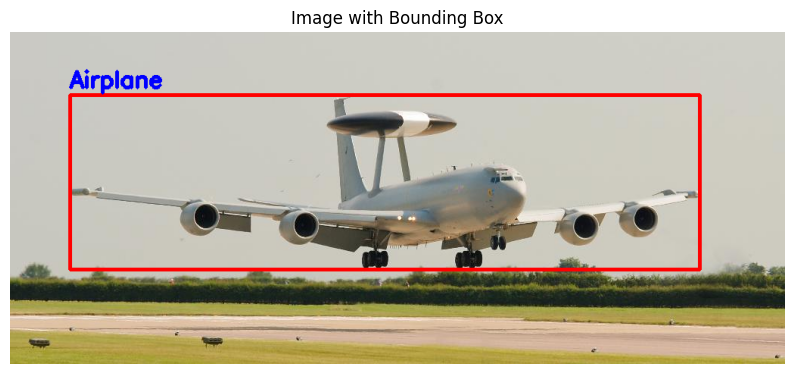

In [42]:
from skimage import io
import matplotlib.pyplot as plt

df = pd.read_csv('open_images_v4/class-descriptions-boxable.csv', header=None)

image = io.imread("open_images_v4/valid/images/ff6164da8de8cd1f.jpg")
f =  open("open_images_v4/valid/labels/ff6164da8de8cd1f.txt", 'r+')
txt = f.read()
print(image.shape)
print(txt)
for text in txt.split('\n'):
    a, x_cent, y_cent, width, height = text.split()
    x_cent = float(x_cent)*image.shape[1]
    width = float(width)*image.shape[1]
    y_cent = float(y_cent)*image.shape[0]
    height = float(height)*image.shape[0]
    x1 = int((x_cent)-width/2)
    x2 = int((x_cent)+width/2)
    y1 = int((y_cent)-height/2)
    y2 = int((y_cent)+height/2)
    cv2.rectangle(image, (x1,y1), (x2, y2), (255, 0, 0), 3)

    label_name = df[1].iloc[int(a)]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, label_name, (x1,y1-10), font, 1, (0,0,255), 3)
plt.figure(figsize=(10,10))
plt.title('Image with Bounding Box')
plt.imshow(image)
plt.axis("off")
plt.show()

(718, 1024, 3)
42 0.0560445 0.42739150000000004 0.070949 0.02499699999999999
42 0.5245865000000001 0.523905 0.683949 0.392044
42 0.701684 0.4815505 0.33387999999999995 0.17854499999999995
105 0.056112 0.424732 0.068108 0.03283999999999998
105 0.780854 0.480156 0.16883599999999999 0.16557000000000005


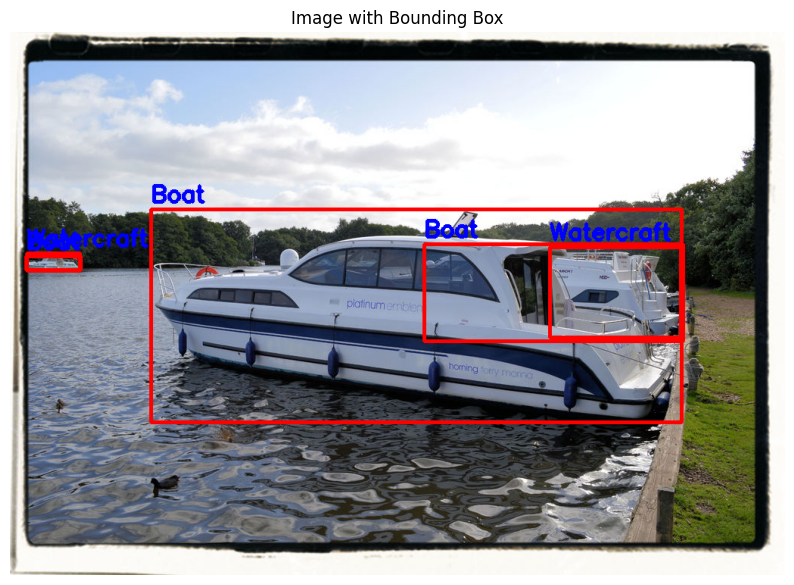

In [46]:
from skimage import io
import matplotlib.pyplot as plt

df = pd.read_csv('open_images_v4/class-descriptions-boxable.csv', header=None)

image = io.imread("open_images_v4/valid/images/ff489fc5652d0162.jpg")
f =  open("open_images_v4/valid/labels/ff489fc5652d0162.txt", 'r+')
txt = f.read()
print(image.shape)
print(txt)
for text in txt.split('\n'):
    a, x_cent, y_cent, width, height = text.split()
    x_cent = float(x_cent)*image.shape[1]
    width = float(width)*image.shape[1]
    y_cent = float(y_cent)*image.shape[0]
    height = float(height)*image.shape[0]
    x1 = int((x_cent)-width/2)
    x2 = int((x_cent)+width/2)
    y1 = int((y_cent)-height/2)
    y2 = int((y_cent)+height/2)
    cv2.rectangle(image, (x1,y1), (x2, y2), (255, 0, 0), 3)

    label_name = df[1].iloc[int(a)]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, label_name, (x1,y1-10), font, 1, (0,0,255), 3)
plt.figure(figsize=(10,10))
plt.title('Image with Bounding Box')
plt.imshow(image)
plt.axis("off")
plt.show()

(1024, 768, 3)
240 0.5258335 0.4653125 0.8983329999999999 0.7518750000000001
240 0.5258335 0.4653125 0.8983329999999999 0.7518750000000001
307 0.536667 0.49 0.14500000000000002 0.34875000000000006
307 0.225833 0.6009375 0.15000000000000002 0.21062500000000006
307 0.2633335 0.4215625 0.11666699999999999 0.17562500000000003
307 0.37625 0.53625 0.200834 0.32625
307 0.7112499999999999 0.6225 0.23250000000000004 0.3175
307 0.755417 0.41375000000000006 0.2024999999999999 0.3350000000000001


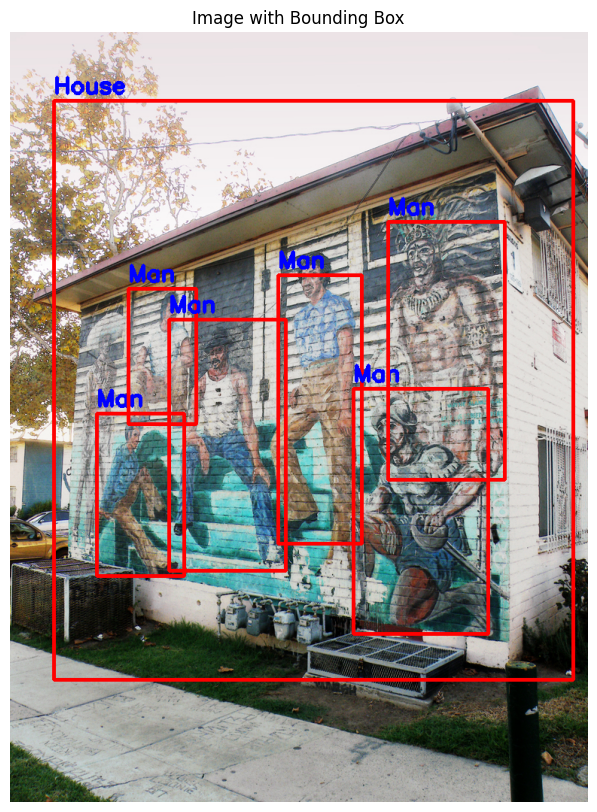

In [61]:
from skimage import io
import matplotlib.pyplot as plt

df = pd.read_csv('open_images_v4/class-descriptions-boxable.csv', header=None)

image = io.imread("open_images_v4/train/images/0117b98d81fe6d1c.jpg")
f =  open("open_images_v4/train/labels/0117b98d81fe6d1c.txt", 'r+')
txt = f.read()
print(image.shape)
print(txt)
for text in txt.split('\n'):
    a, x_cent, y_cent, width, height = text.split()
    x_cent = float(x_cent)*image.shape[1]
    width = float(width)*image.shape[1]
    y_cent = float(y_cent)*image.shape[0]
    height = float(height)*image.shape[0]
    x1 = int((x_cent)-width/2)
    x2 = int((x_cent)+width/2)
    y1 = int((y_cent)-height/2)
    y2 = int((y_cent)+height/2)
    cv2.rectangle(image, (x1,y1), (x2, y2), (255, 0, 0), 3)

    label_name = df[1].iloc[int(a)]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, label_name, (x1,y1-10), font, 1, (0,0,255), 3)
plt.figure(figsize=(10,10))
plt.title('Image with Bounding Box')
plt.imshow(image)
plt.axis("off")
plt.show()